# Mount and import

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mode
import plotly.express as px

In [4]:
loan = pd.read_csv('/content/drive/MyDrive/dataset/Moneylion/loan.csv')
payment = pd.read_csv('/content/drive/MyDrive/dataset/Moneylion/payment.csv')
clarity = pd.read_csv('/content/drive/MyDrive/dataset/Moneylion/clarity_underwriting_variables.csv')


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (9,11,12,13,14,15,16,17,18,19,20,21,22,23,25,26,27,28,29,31,32,33,36,37) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


#EDA

##Inspect loan df

In [5]:
#df shape
print(clarity.shape, loan.shape, payment.shape)

(49752, 54) (577682, 19) (689364, 9)


In [6]:
#loan.head()
loan.info()
loan.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577682 entries, 0 to 577681
Data columns (total 19 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   loanId                            577426 non-null  object 
 1   anon_ssn                          577682 non-null  object 
 2   payFrequency                      576409 non-null  object 
 3   apr                               573760 non-null  float64
 4   applicationDate                   577682 non-null  object 
 5   originated                        577682 non-null  bool   
 6   originatedDate                    46044 non-null   object 
 7   nPaidOff                          577658 non-null  float64
 8   approved                          577682 non-null  bool   
 9   isFunded                          577682 non-null  int64  
 10  loanStatus                        577291 non-null  object 
 11  loanAmount                        575432 non-null  f

,apr,nPaidOff,isFunded,loanAmount,originallyScheduledPaymentAmount,leadCost,hasCF
count,573760.000000,577658.000000,577682.000000,575432.000000,577682.000000,577682.000000,577682.000000
mean,553.080972,0.037887,0.067480,514.245084,1428.897209,7.854389,0.619187
std,110.046159,0.333366,0.250852,320.939929,925.009141,12.853451,0.485587
min,0.000000,0.000000,0.000000,0.000000,-816.710000,0.000000,0.000000
25%,490.000000,0.000000,0.000000,350.000000,1023.640000,3.000000,0.000000
50%,590.000000,0.000000,0.000000,500.000000,1245.250000,3.000000,1.000000
75%,601.000000,0.000000,0.000000,500.000000,1615.660000,6.000000,1.000000
max,705.590000,21.000000,1.000000,5000.000000,19963.630000,200.000000,1.000000


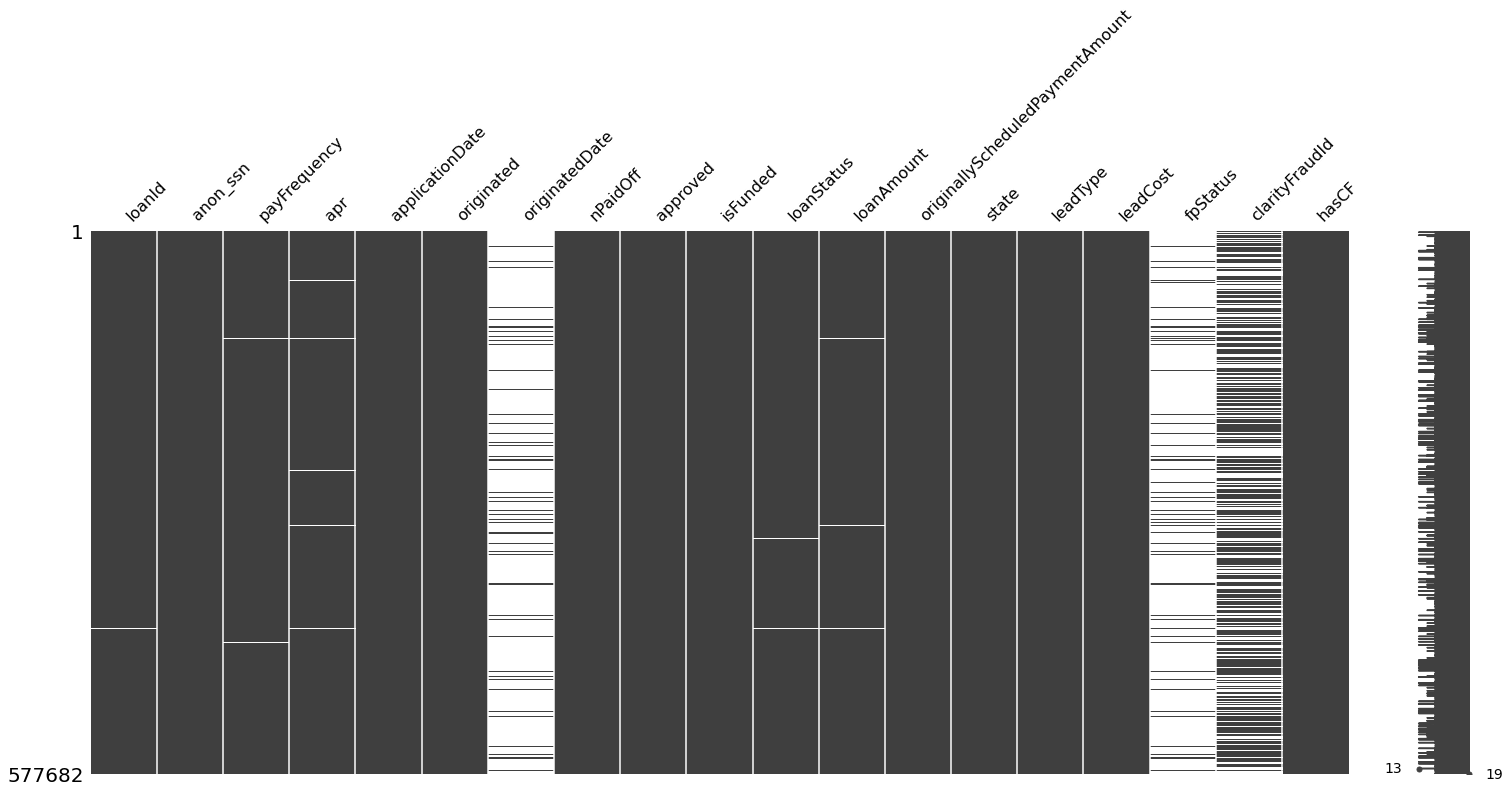

In [7]:
import missingno as mn
mn.matrix(loan) #Show the null value within each feature

In [8]:
loan.nunique()

loanId                              577426
anon_ssn                            459393
payFrequency                             5
apr                                    130
applicationDate                     577624
originated                               2
originatedDate                       46042
nPaidOff                                22
approved                                 2
isFunded                                 2
loanStatus                              21
loanAmount                             564
originallyScheduledPaymentAmount     80784
state                                   44
leadType                                10
leadCost                                15
fpStatus                                 8
clarityFraudId                      314915
hasCF                                    2
dtype: int64

In [9]:
#Converting Categorical columns
loan_cat_col = ['payFrequency','originated','approved','isFunded',
                'loanStatus','state','leadType','fpStatus','hasCF']
for col in loan_cat_col:
    loan[col] =pd.Categorical(loan[col])


Quetions:
- Distribution of each categorical feature? 
- how many ssn with application >1? *Unique (ssn < loan id) but Count(ssn > loan id)*
  - 118033
- Why min('originallyScheduledPaymentAmount') = negative
  - 1 outlier (index = 526900 (deleted)
- 'hasCF'?? 1 = has fraudID? 
  - CF(1) = fraudID
- Why na('OriginatedDate') is high while na('Originated') = 0?
  - cuz most of it are not originated
  


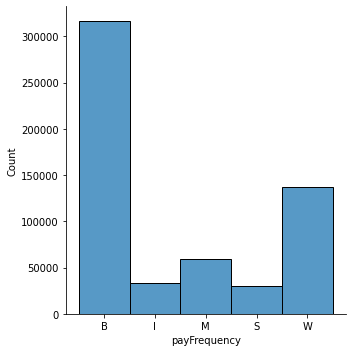

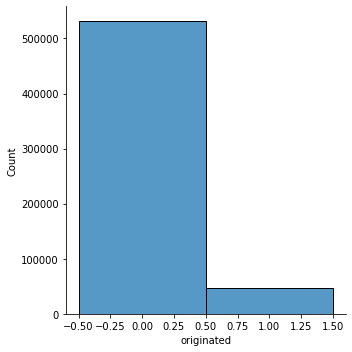

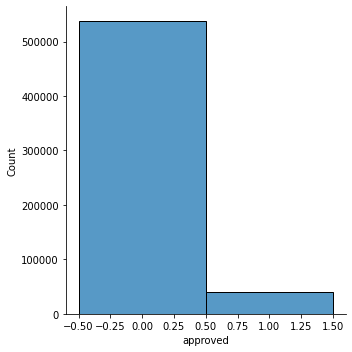

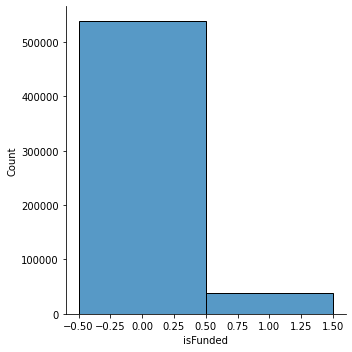

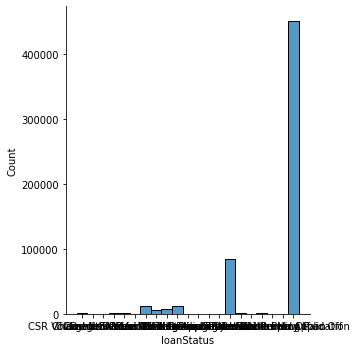

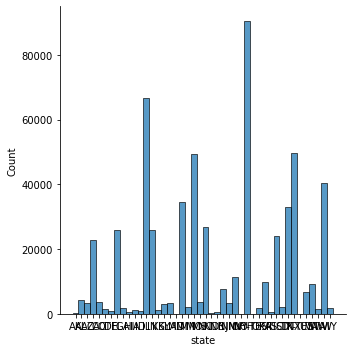

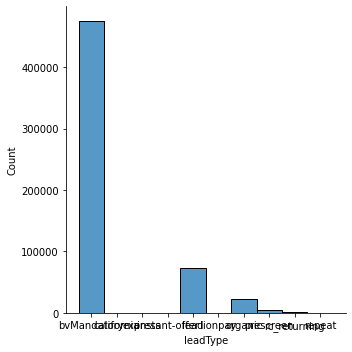

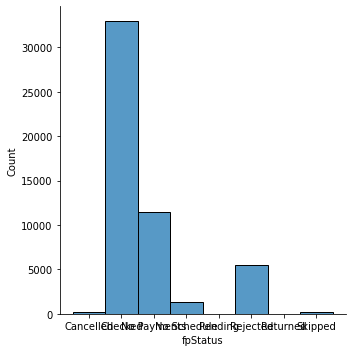

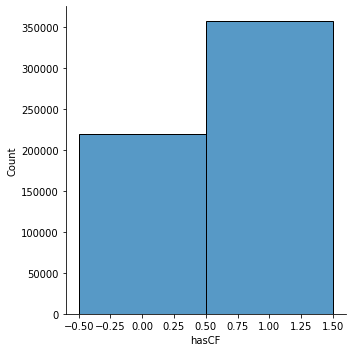

In [10]:
for col in loan_cat_col:
  sns.displot(loan[col])

Most of it are Biweekly and Weekly payments

[originated, approved, isfunded] = 1 decrease gradually as they are consecutive steps
- Most of it are not originated/approved/funded

Unclear: Check numbers of loanStatus, state, leadType, fpStatus

HasCF(1) around 350000 == count(FraudID)


In [11]:
loan['loanStatus'].value_counts(normalize =True) 

Withdrawn Application          0.781207
Rejected                       0.147361
Paid Off Loan                  0.019794
External Collection            0.019633
New Loan                       0.014052
Internal Collection            0.009643
Returned Item                  0.002047
CSR Voided New Loan            0.001777
Settlement Paid Off            0.001226
Credit Return Void             0.001219
Customer Voided New Loan       0.000873
Settled Bankruptcy             0.000565
Pending Paid Off               0.000293
Charged Off Paid Off           0.000277
Pending Application Fee        0.000009
Pending Rescind                0.000007
Pending Application            0.000007
Voided New Loan                0.000003
Customver Voided New Loan      0.000002
Charged Off                    0.000002
Settlement Pending Paid Off    0.000002
Name: loanStatus, dtype: float64

Majority are withdrawn and rejected application (90%+)

In [12]:
loan['state'].value_counts(normalize =True).head(5)#.sum()   
#Top 5 area

OH    0.156689
IL    0.115505
TX    0.086103
MO    0.085272
WI    0.069862
Name: state, dtype: float64

More than 50% of applicant are come from those state

In [13]:
loan['leadType'].value_counts(normalize =True) 

bvMandatory      0.822253
lead             0.125801
organic          0.039556
prescreen        0.007816
rc_returning     0.003582
california       0.000829
lionpay          0.000045
repeat           0.000042
express          0.000038
instant-offer    0.000038
Name: leadType, dtype: float64

Majority are leads from ping tree (some kind of lead generator?)

82% are required to perform bank verification before approval

In [14]:
#fill in the null and merge "No Schedule": "No Payments"
loan["fpStatus"].replace({"No Schedule": "No Payments", None: "No ACH"}, inplace=True)
loan['fpStatus'].value_counts(normalize =True)

No ACH         0.910465
Checked        0.057087
No Payments    0.022071
Rejected       0.009559
Cancelled      0.000431
Skipped        0.000377
Pending        0.000009
Returned       0.000002
Name: fpStatus, dtype: float64

90%+ are no ACH


In [15]:
loan.loanId.nunique()-loan.anon_ssn.nunique()
#ssn with >1 application = 118033

118033

In [16]:
loan[loan.originallyScheduledPaymentAmount <0].describe() #<=0 : 11923 rows as they are not funded; 
                                                          #<0 : ONLY 1 outlier with -816 originallyScheduledPaymentAmount
loan.index[loan.originallyScheduledPaymentAmount <0] #Int64Index([526900], dtype='int64')
loan.drop([526900], axis=0, inplace=True)

In [17]:
check = loan[loan['hasCF'].eq(0)] #if hasCF =0
round(check.isnull().sum() / check.shape[0] * 100.00,2) #clarityFraudID null = 0%, otherwise CF=0, null = 100%
#both can delete later after merging

loanId                                0.07
anon_ssn                              0.00
payFrequency                          0.04
apr                                   1.15
applicationDate                       0.00
originated                            0.00
originatedDate                       96.91
nPaidOff                              0.01
approved                              0.00
isFunded                              0.00
loanStatus                            0.09
loanAmount                            0.41
originallyScheduledPaymentAmount      0.00
state                                 0.00
leadType                              0.00
leadCost                              0.00
fpStatus                              0.00
clarityFraudId                      100.00
hasCF                                 0.00
dtype: float64

In [18]:
check = loan[loan['originated'].eq(1)] #if =1, no null in originated date
round(check['originatedDate'].isnull().sum() / check.shape[0] * 100.00,2)

0.0

##Inspect Payment df

In [19]:
#payment.head()
payment.info()
payment.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 689364 entries, 0 to 689363
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   loanId             689364 non-null  object 
 1   installmentIndex   689364 non-null  int64  
 2   isCollection       689364 non-null  bool   
 3   paymentDate        689364 non-null  object 
 4   principal          689364 non-null  float64
 5   fees               689364 non-null  float64
 6   paymentAmount      689364 non-null  float64
 7   paymentStatus      689364 non-null  object 
 8   paymentReturnCode  31533 non-null   object 
dtypes: bool(1), float64(3), int64(1), object(4)
memory usage: 42.7+ MB


,installmentIndex,principal,fees,paymentAmount
count,689364.000000,689364.000000,689364.000000,689364.000000
mean,10.553222,45.557543,67.003994,112.680232
std,8.049530,81.724683,59.789510,105.783710
min,1.000000,-303.370000,-42.560000,-337.700000
25%,5.000000,13.180000,28.820000,56.810000
50%,9.000000,27.610000,51.300000,86.340000
75%,14.000000,53.380000,86.440000,135.090000
max,105.000000,4000.000000,1257.710000,4063.600000


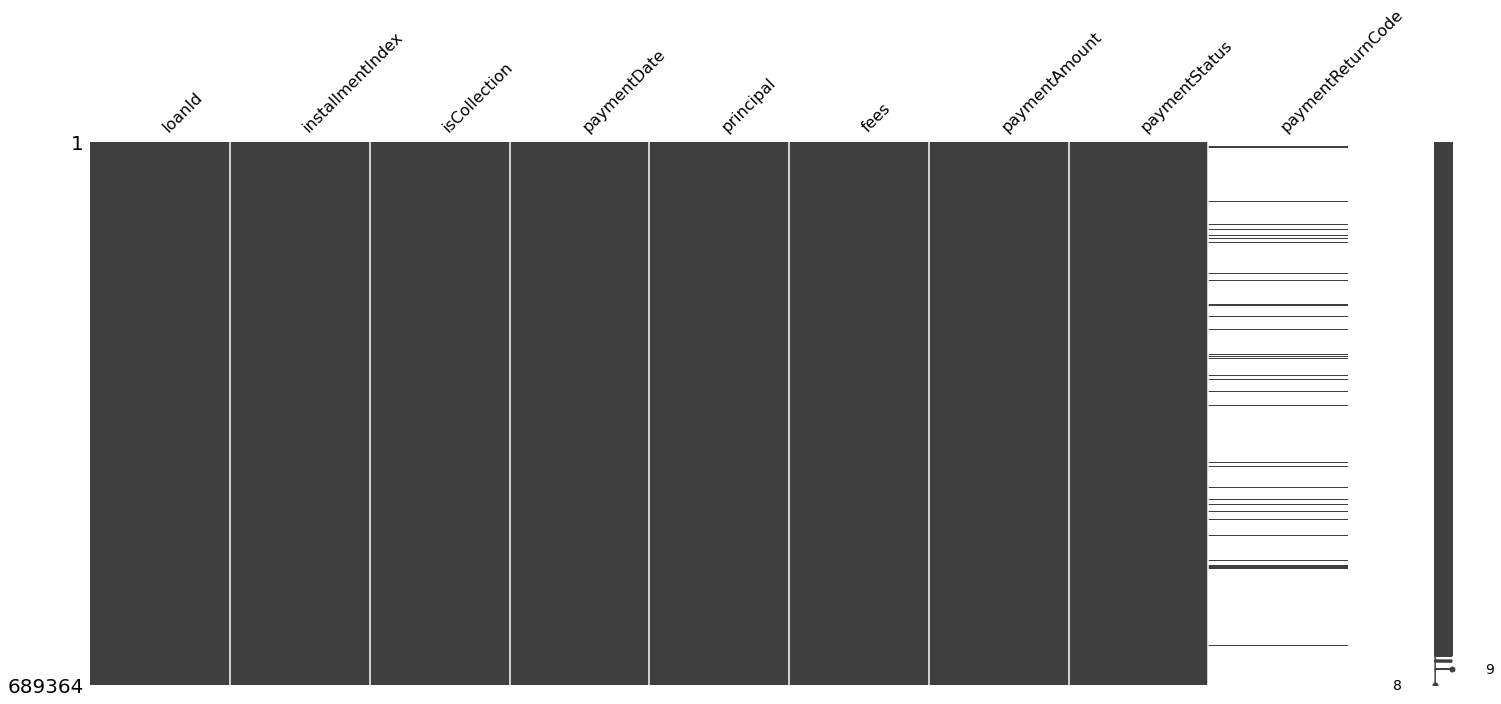

In [20]:
mn.matrix(payment) #Show the null value within each feature

In [21]:
payment.nunique()

loanId               39952
installmentIndex       105
isCollection             2
paymentDate          18436
principal            26886
fees                 29779
paymentAmount        27013
paymentStatus            9
paymentReturnCode       31
dtype: int64

In [22]:
#Converting Categorical columns
pay_cat_col = ['isCollection','paymentStatus','paymentReturnCode']
for col in pay_cat_col:
    payment[col] =pd.Categorical(payment[col])

In [23]:
check = payment.sort_values(['loanId'])
check.head(15)

,loanId,installmentIndex,isCollection,paymentDate,principal,fees,paymentAmount,paymentStatus,paymentReturnCode
0,LL-I-00000021,1,False,2014-12-19T05:00:00,22.33,147.28,169.61,Checked,NaN
12,LL-I-00000021,1,True,2016-04-28T22:44:43.736000,0.01,0.00,0.01,Checked,NaN
10,LL-I-00000021,11,False,2015-05-08T04:00:00,120.98,48.63,169.61,Checked,NaN
9,LL-I-00000021,10,False,2015-04-24T04:00:00,102.17,67.44,169.61,Rejected,R01
8,LL-I-00000021,9,False,2015-04-10T04:00:00,86.29,83.32,169.61,Checked,NaN
7,LL-I-00000021,8,False,2015-03-27T04:00:00,72.87,96.74,169.61,Checked,NaN
11,LL-I-00000021,12,False,2015-05-22T04:00:00,143.15,26.35,169.50,Checked,NaN
5,LL-I-00000021,6,False,2015-02-27T05:00:00,51.97,117.64,169.61,Checked,NaN
4,LL-I-00000021,5,False,2015-02-13T05:00:00,43.89,125.72,169.61,Checked,NaN
3,LL-I-00000021,4,False,2015-01-30T05:00:00,37.07,132.54,169.61,Checked,NaN


count(ID) > unique(ID), (Each row = 1 ACH attempt) == alot of repeat ID

Questions:
- How many ACH attempts for each value in 'paymentStatus'? 'isCollection'? 

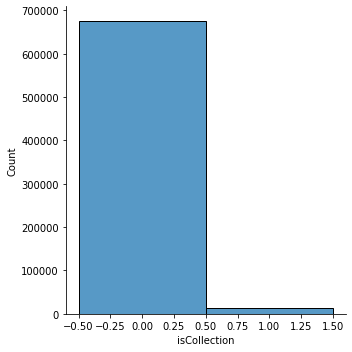

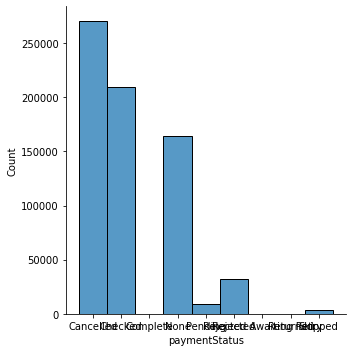

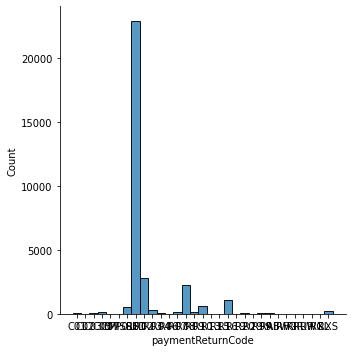

In [24]:
for col in pay_cat_col:
  sns.displot(payment[col])

Most of this are not collection.


Unclear: Check numbers of paymentReturnCode, paymentStatus



In [25]:
payment['paymentReturnCode'].value_counts(normalize =True) 

R01       0.725145
R02       0.087559
R08       0.071639
R16       0.034408
R10       0.019662
MISSED    0.017030
R03       0.010085
RXS       0.007167
R09       0.005581
R07       0.005074
C05       0.003362
C01       0.002759
R20       0.002632
R99       0.001903
RAF       0.001839
R04       0.001237
C03       0.001078
C02       0.000317
RWC       0.000222
LPP01     0.000222
RUP       0.000190
R06       0.000190
RBW       0.000159
R29       0.000127
R15       0.000095
RFG       0.000095
C07       0.000063
R13       0.000063
RIR       0.000032
RXL       0.000032
R19       0.000032
Name: paymentReturnCode, dtype: float64

In [26]:
payment['paymentStatus'].value_counts(normalize =True) 

Cancelled                  0.392150
Checked                    0.304079
None                       0.237983
Rejected                   0.046898
Pending                    0.013405
Skipped                    0.005456
Rejected Awaiting Retry    0.000026
Complete                   0.000001
Returned                   0.000001
Name: paymentStatus, dtype: float64

In [27]:
# Drop value with ['Rejected Awaiting Retry','Complete','Returned']
payment1 = pd.read_csv('/content/drive/MyDrive/dataset/Moneylion/payment.csv')
payment1 = payment1.drop(payment.index[payment['paymentStatus'].isin(['Rejected Awaiting Retry','Complete','Returned'])])

In [28]:
payment1['paymentStatus'].value_counts(normalize =True) 

Cancelled    0.392161
Checked      0.304088
None         0.237990
Rejected     0.046900
Pending      0.013405
Skipped      0.005456
Name: paymentStatus, dtype: float64

In [29]:
dummy = payment1[['loanId','paymentStatus']]
a = pd.get_dummies(dummy, columns=['paymentStatus'])
payment_status = a.groupby('loanId').sum()
#payment_status.reset_index(inplace = True)
payment_status.nunique()

paymentStatus_Cancelled    72
paymentStatus_Checked      44
paymentStatus_None         53
paymentStatus_Pending       4
paymentStatus_Rejected     13
paymentStatus_Skipped       7
dtype: int64

In [30]:
payment_status.head()
#payment_status.shape#(39952, 6)

,paymentStatus_Cancelled,paymentStatus_Checked,paymentStatus_None,paymentStatus_Pending,paymentStatus_Rejected,paymentStatus_Skipped
loanId,,,,,,
LL-I-00000021,0,12,0,0,1,0
LL-I-00000231,8,2,8,0,2,0
LL-I-00000238,4,7,4,0,1,0
LL-I-00000308,10,1,10,0,1,0
LL-I-00000355,11,0,11,0,1,0


In [31]:
dummy = payment1[['loanId','isCollection']]
a = pd.get_dummies(dummy, columns=['isCollection'])
collection = a.groupby('loanId').sum()
#payment_status.reset_index(inplace = True)
collection.nunique()

isCollection_False    61
isCollection_True     42
dtype: int64

In [32]:
collection.head()

,isCollection_False,isCollection_True
loanId,,
LL-I-00000021,12,1
LL-I-00000231,20,0
LL-I-00000238,16,0
LL-I-00000308,22,0
LL-I-00000355,23,0


In [33]:
payment1.head(20) 

,loanId,installmentIndex,isCollection,paymentDate,principal,fees,paymentAmount,paymentStatus,paymentReturnCode
0,LL-I-00000021,1,False,2014-12-19T05:00:00,22.33,147.28,169.61,Checked,NaN
1,LL-I-00000021,2,False,2015-01-02T05:00:00,26.44,143.17,169.61,Checked,NaN
2,LL-I-00000021,3,False,2015-01-16T05:00:00,31.30,138.31,169.61,Checked,NaN
3,LL-I-00000021,4,False,2015-01-30T05:00:00,37.07,132.54,169.61,Checked,NaN
4,LL-I-00000021,5,False,2015-02-13T05:00:00,43.89,125.72,169.61,Checked,NaN
5,LL-I-00000021,6,False,2015-02-27T05:00:00,51.97,117.64,169.61,Checked,NaN
6,LL-I-00000021,7,False,2015-03-13T04:00:00,61.54,108.07,169.61,Checked,NaN
7,LL-I-00000021,8,False,2015-03-27T04:00:00,72.87,96.74,169.61,Checked,NaN
8,LL-I-00000021,9,False,2015-04-10T04:00:00,86.29,83.32,169.61,Checked,NaN
9,LL-I-00000021,10,False,2015-04-24T04:00:00,102.17,67.44,169.61,Rejected,R01


In [34]:
installment = payment1[['loanId', 'installmentIndex', 'paymentAmount']]
installment=installment.sort_values(['loanId','installmentIndex']).drop_duplicates(['loanId'],keep='last')
installment.head(15) #get  'paymentAmount' at final success payment
#installment.shape #(39952, 4)

,loanId,installmentIndex,paymentAmount
11,LL-I-00000021,12,169.50
32,LL-I-00000231,20,174.35
48,LL-I-00000238,16,174.35
70,LL-I-00000308,22,61.59
93,LL-I-00000355,23,108.96
149,LL-I-00000419,21,152.55
128,LL-I-00000614,23,169.50
105,LL-I-00001902,12,106.00
168,LL-I-00002130,19,108.96
190,LL-I-00002148,22,200.74


In [35]:
return_code = payment1[['loanId', 'paymentReturnCode']]

return_code = return_code.groupby('loanId').paymentReturnCode.agg(lambda x: mode(x).mode)
return_code.value_counts()

0         22056
R01       11089
R02        2143
R08        2055
R16        1018
R10         306
R03         282
MISSED      259
RXS         181
R07         127
R09         114
R20          81
C01          48
RAF          37
R04          36
C03          33
R99          28
C05          19
LPP01         7
RUP           6
C02           5
RBW           4
R06           4
R29           4
RWC           3
R13           2
RXL           1
RIR           1
R15           1
R19           1
C07           1
Name: paymentReturnCode, dtype: int64

In [36]:
left_merged = pd.merge(payment_status, collection, how="left", on=["loanId"])
left_merged = pd.merge(left_merged, installment, how="left", on=["loanId"])
cleaned_pay = pd.merge(left_merged, return_code, how="left", on=["loanId"])
#cleaned_pay.shape 
cleaned_pay

,loanId,paymentStatus_Cancelled,paymentStatus_Checked,paymentStatus_None,paymentStatus_Pending,paymentStatus_Rejected,paymentStatus_Skipped,isCollection_False,isCollection_True,installmentIndex,paymentAmount,paymentReturnCode
0,LL-I-00000021,0,12,0,0,1,0,12,1,12,169.50,R01
1,LL-I-00000231,8,2,8,0,2,0,20,0,20,174.35,R01
2,LL-I-00000238,4,7,4,0,1,0,16,0,16,174.35,R08
3,LL-I-00000308,10,1,10,0,1,0,22,0,22,61.59,R08
4,LL-I-00000355,11,0,11,0,1,0,23,0,23,108.96,R02
...,...,...,...,...,...,...,...,...,...,...,...,...
39947,LP-I-00000127,0,12,0,0,0,0,12,0,12,72.71,0
39948,LP-I-00000134,6,1,0,0,0,0,7,0,7,155.91,0
39949,LP-I-00000139,0,12,0,0,3,0,15,0,15,75.86,R01
39950,LP-I-00000142,12,0,0,0,0,1,13,0,13,60.79,0


In [37]:
cleaned_pay.isnull().sum()

loanId                     0
paymentStatus_Cancelled    0
paymentStatus_Checked      0
paymentStatus_None         0
paymentStatus_Pending      0
paymentStatus_Rejected     0
paymentStatus_Skipped      0
isCollection_False         0
isCollection_True          0
installmentIndex           0
paymentAmount              0
paymentReturnCode          0
dtype: int64

By doing this, we can retain most of the informations

##Inspect Clarity df

In [38]:
clarity = pd.read_csv('/content/drive/MyDrive/dataset/Moneylion/clarity_underwriting_variables.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (9,11,12,13,14,15,16,17,18,19,20,21,22,23,25,26,27,28,29,31,32,33,36,37) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [39]:
#clarity.head()
clarity.info()
clarity.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49752 entries, 0 to 49751
Data columns (total 54 columns):
 #   Column                                                                                               Non-Null Count  Dtype  
---  ------                                                                                               --------------  -----  
 0   .underwritingdataclarity.clearfraud.clearfraudinquiry.thirtydaysago                                  49750 non-null  float64
 1   .underwritingdataclarity.clearfraud.clearfraudinquiry.twentyfourhoursago                             49750 non-null  float64
 2   .underwritingdataclarity.clearfraud.clearfraudinquiry.oneminuteago                                   49750 non-null  float64
 3   .underwritingdataclarity.clearfraud.clearfraudinquiry.onehourago                                     49750 non-null  float64
 4   .underwritingdataclarity.clearfraud.clearfraudinquiry.ninetydaysago                                  49750

,.underwritingdataclarity.clearfraud.clearfraudinquiry.thirtydaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.twentyfourhoursago,.underwritingdataclarity.clearfraud.clearfraudinquiry.oneminuteago,.underwritingdataclarity.clearfraud.clearfraudinquiry.onehourago,.underwritingdataclarity.clearfraud.clearfraudinquiry.ninetydaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.sevendaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.tenminutesago,.underwritingdataclarity.clearfraud.clearfraudinquiry.fifteendaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.threesixtyfivedaysago,.underwritingdataclarity.clearfraud.clearfraudindicator.totalnumberoffraudindicators,.underwritingdataclarity.clearfraud.clearfraudindicator.maxnumberofssnswithanybankaccount,.underwritingdataclarity.clearfraud.clearfraudidentityverification.overallmatchreasoncode,clearfraudscore
count,49750.000000,49750.000000,49750.000000,49750.000000,49750.000000,49750.000000,49750.000000,49750.000000,49750.000000,49735.000000,49735.000000,49720.000000,49615.000000
mean,7.313628,4.601990,2.343980,4.006874,10.554513,5.423799,3.292121,6.155578,20.302291,2.118327,7.202554,11.728842,683.769787
std,6.327122,3.302288,1.436345,2.697831,10.450845,4.110483,2.109667,4.952620,23.771239,1.254602,79.908530,14.116701,126.205372
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,122.000000
25%,3.000000,3.000000,1.000000,3.000000,4.000000,3.000000,2.000000,3.000000,6.000000,1.000000,1.000000,1.000000,592.000000
50%,5.000000,3.000000,3.000000,3.000000,7.000000,4.000000,3.000000,5.000000,12.000000,2.000000,1.000000,11.000000,691.000000
75%,9.000000,5.000000,3.000000,5.000000,13.000000,6.000000,4.000000,7.000000,25.000000,3.000000,2.000000,15.000000,783.000000
max,89.000000,60.000000,16.000000,42.000000,202.000000,64.000000,35.000000,83.000000,438.000000,8.000000,4056.000000,125.000000,965.000000


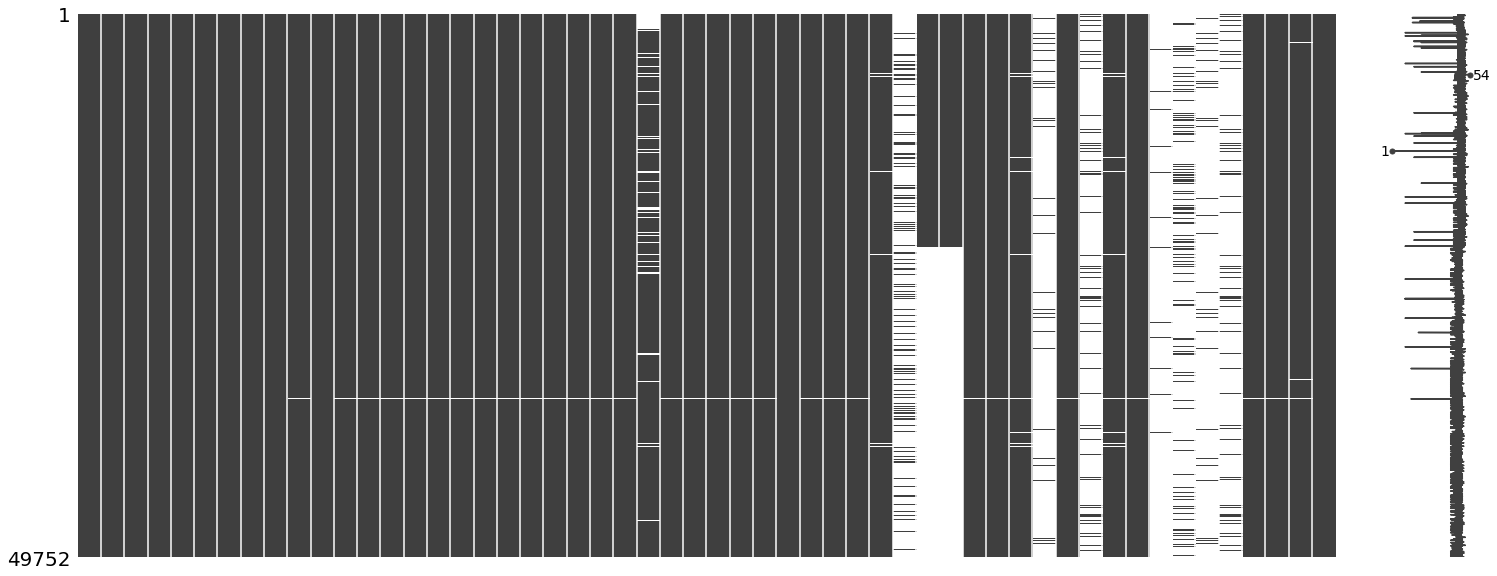

In [40]:
mn.matrix(clarity) #Show the null value within each feature

In [41]:
clarity.nunique()

.underwritingdataclarity.clearfraud.clearfraudinquiry.thirtydaysago                                       79
.underwritingdataclarity.clearfraud.clearfraudinquiry.twentyfourhoursago                                  47
.underwritingdataclarity.clearfraud.clearfraudinquiry.oneminuteago                                        15
.underwritingdataclarity.clearfraud.clearfraudinquiry.onehourago                                          36
.underwritingdataclarity.clearfraud.clearfraudinquiry.ninetydaysago                                      121
.underwritingdataclarity.clearfraud.clearfraudinquiry.sevendaysago                                        54
.underwritingdataclarity.clearfraud.clearfraudinquiry.tenminutesago                                       29
.underwritingdataclarity.clearfraud.clearfraudinquiry.fifteendaysago                                      65
.underwritingdataclarity.clearfraud.clearfraudinquiry.threesixtyfivedaysago                              235
.underwritingdatacl

In [42]:
#Converting Categorical columns
#clarity.columns
cla_cat_col = ['.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryonfilecurrentaddressconflict',
       '.underwritingdataclarity.clearfraud.clearfraudindicator.totalnumberoffraudindicators',
       '.underwritingdataclarity.clearfraud.clearfraudindicator.telephonenumberinconsistentwithaddress',
       '.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryageyoungerthanssnissuedate',
       '.underwritingdataclarity.clearfraud.clearfraudindicator.onfileaddresscautious',
       '.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryaddressnonresidential',
       '.underwritingdataclarity.clearfraud.clearfraudindicator.onfileaddresshighrisk',
       '.underwritingdataclarity.clearfraud.clearfraudindicator.ssnreportedmorefrequentlyforanother',
       '.underwritingdataclarity.clearfraud.clearfraudindicator.currentaddressreportedbytradeopenlt90days',
       '.underwritingdataclarity.clearfraud.clearfraudindicator.inputssninvalid',
       '.underwritingdataclarity.clearfraud.clearfraudindicator.inputssnissuedatecannotbeverified',
       '.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryaddresscautious',
       '.underwritingdataclarity.clearfraud.clearfraudindicator.morethan3inquiriesinthelast30days',
       '.underwritingdataclarity.clearfraud.clearfraudindicator.onfileaddressnonresidential',
       '.underwritingdataclarity.clearfraud.clearfraudindicator.creditestablishedpriortossnissuedate',
       '.underwritingdataclarity.clearfraud.clearfraudindicator.driverlicenseformatinvalid',
       '.underwritingdataclarity.clearfraud.clearfraudindicator.inputssnrecordedasdeceased',
       '.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryaddresshighrisk',
       '.underwritingdataclarity.clearfraud.clearfraudindicator.inquirycurrentaddressnotonfile',
       '.underwritingdataclarity.clearfraud.clearfraudindicator.bestonfilessnissuedatecannotbeverified',
       '.underwritingdataclarity.clearfraud.clearfraudindicator.highprobabilityssnbelongstoanother',
       '.underwritingdataclarity.clearfraud.clearfraudindicator.maxnumberofssnswithanybankaccount',
       '.underwritingdataclarity.clearfraud.clearfraudindicator.bestonfilessnrecordedasdeceased',
       '.underwritingdataclarity.clearfraud.clearfraudindicator.currentaddressreportedbynewtradeonly',
       '.underwritingdataclarity.clearfraud.clearfraudindicator.creditestablishedbeforeage18',
       '.underwritingdataclarity.clearfraud.clearfraudindicator.telephonenumberinconsistentwithstate',
       '.underwritingdataclarity.clearfraud.clearfraudindicator.driverlicenseinconsistentwithonfile',
       '.underwritingdataclarity.clearfraud.clearfraudindicator.workphonepreviouslylistedascellphone',
       '.underwritingdataclarity.clearfraud.clearfraudindicator.workphonepreviouslylistedashomephone',
       '.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamematch',
       '.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressmatch',
       '.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchtype',
       '.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamereasoncodedescription',
       '.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchresult',
       '.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressreasoncodedescription',
       '.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchtypedescription',
       '.underwritingdataclarity.clearfraud.clearfraudidentityverification.overallmatchresult',
       '.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonetype',
       '.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssndobreasoncode',
       '.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamereasoncode',
       '.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressreasoncode',
       '.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssndobmatch',
       '.underwritingdataclarity.clearfraud.clearfraudidentityverification.overallmatchreasoncode']
for col in cla_cat_col:
    clarity[col] =pd.Categorical(clarity[col])

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

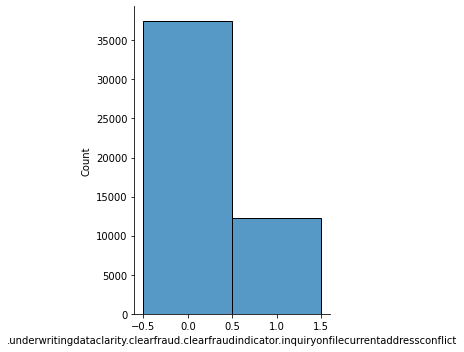

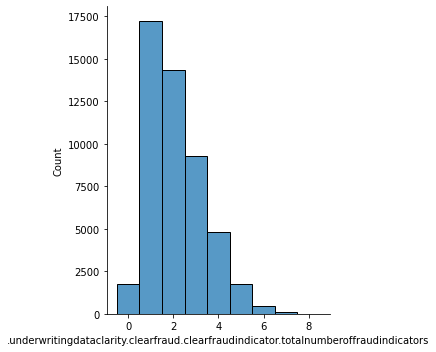

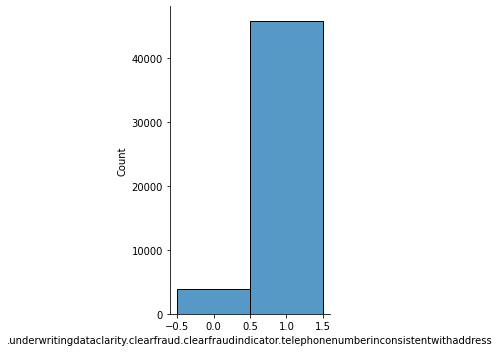

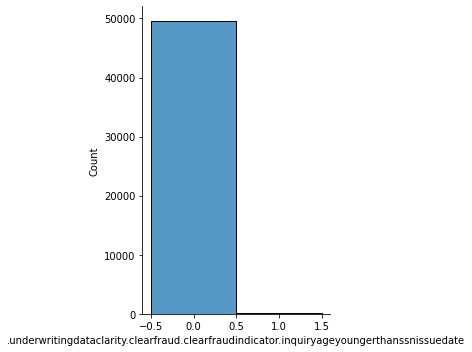

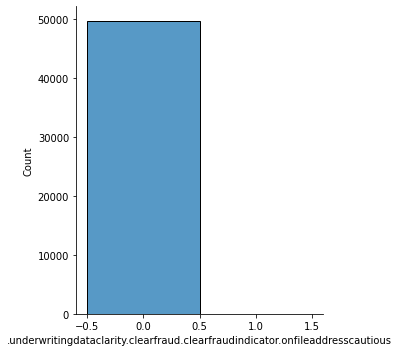

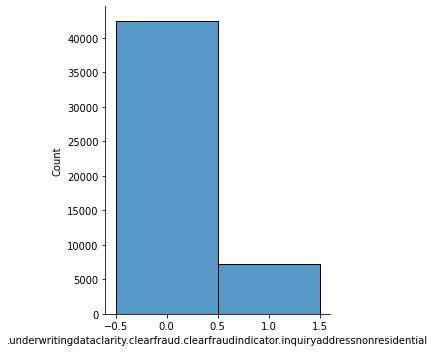

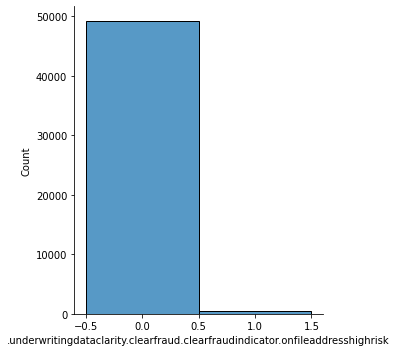

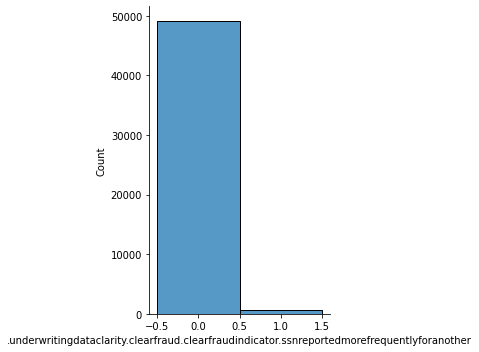

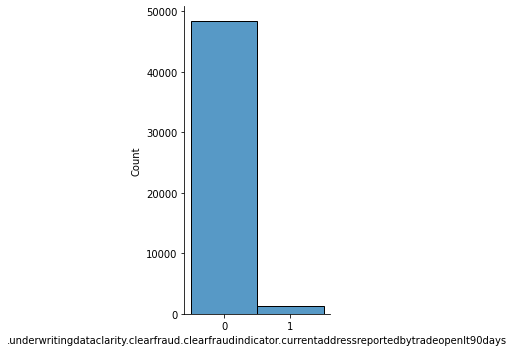

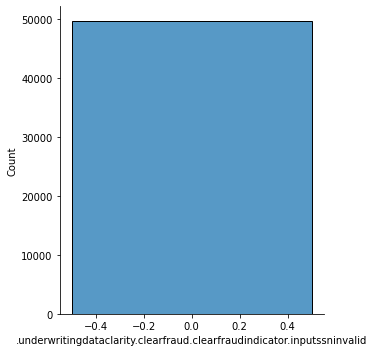

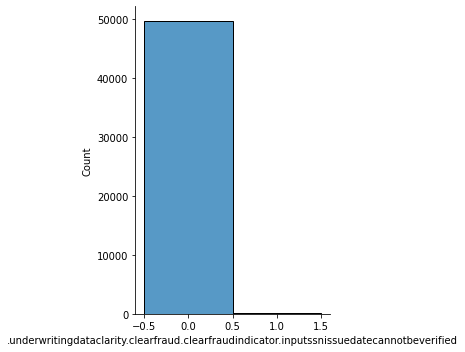

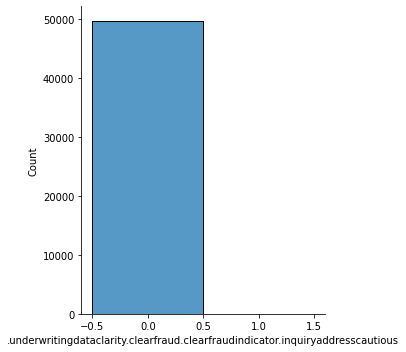

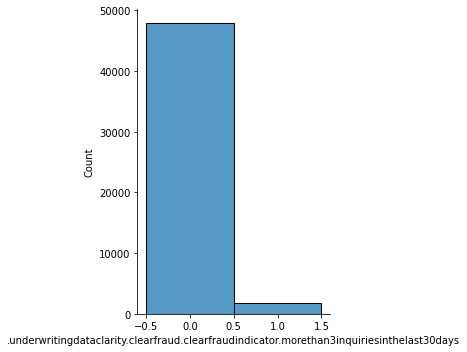

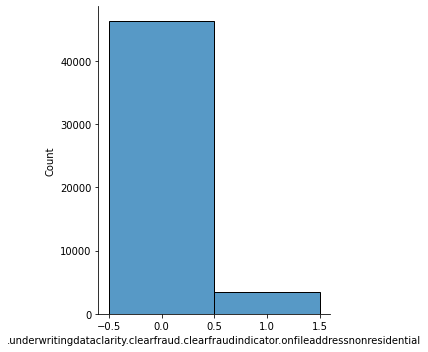

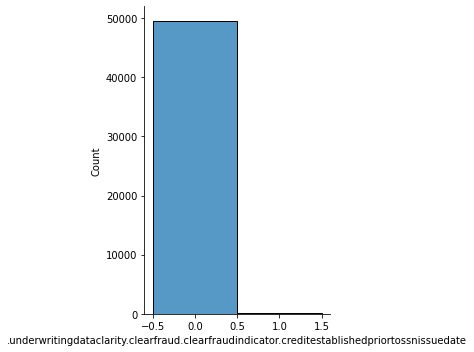

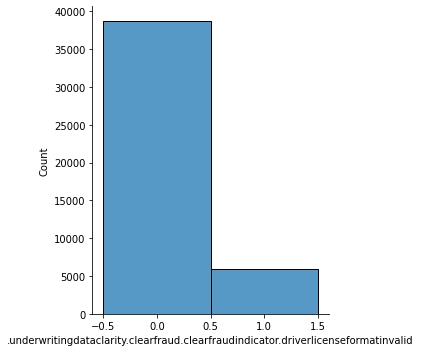

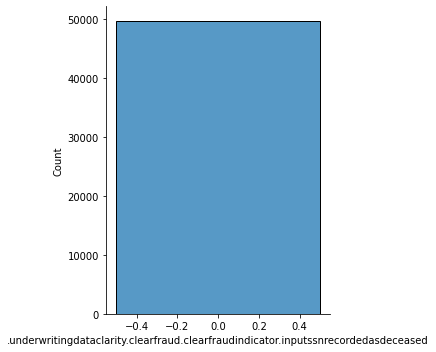

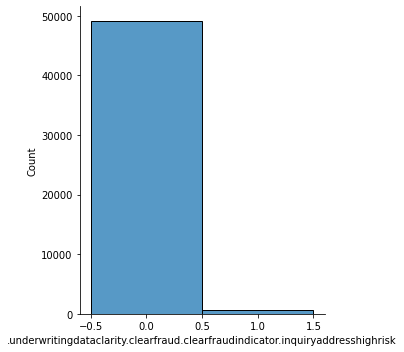

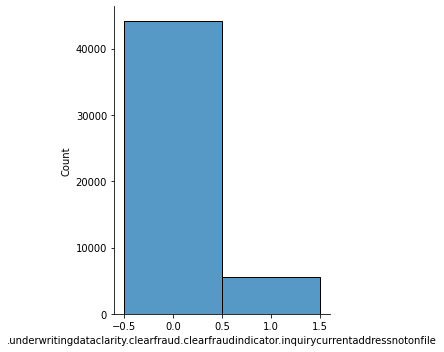

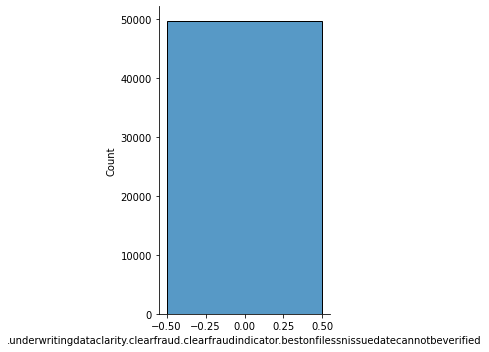

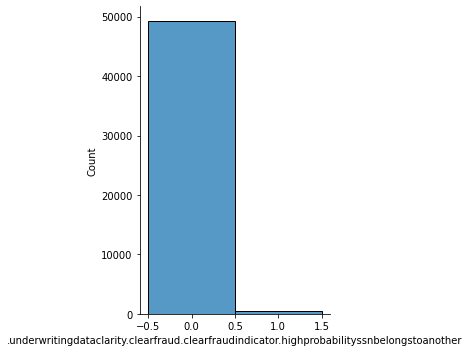

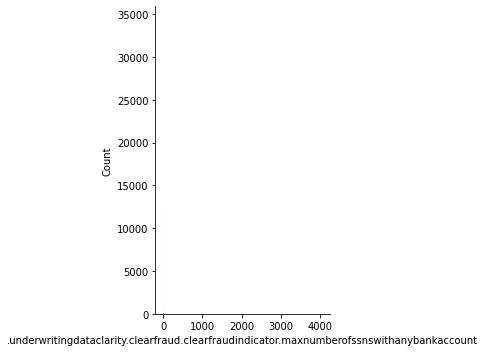

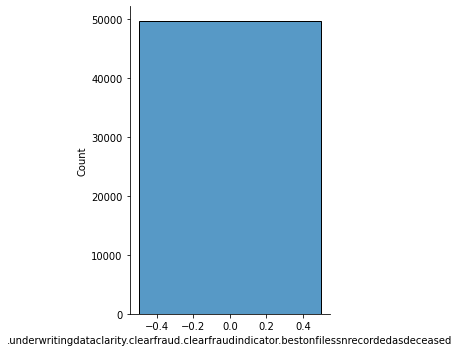

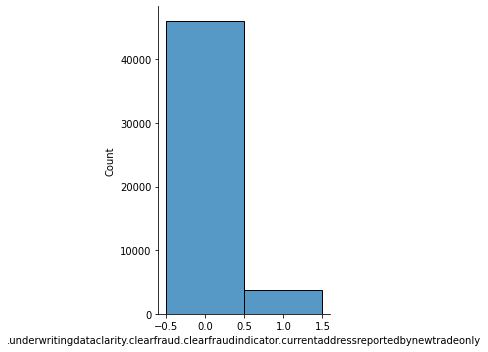

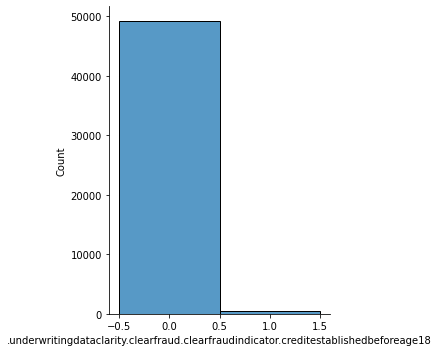

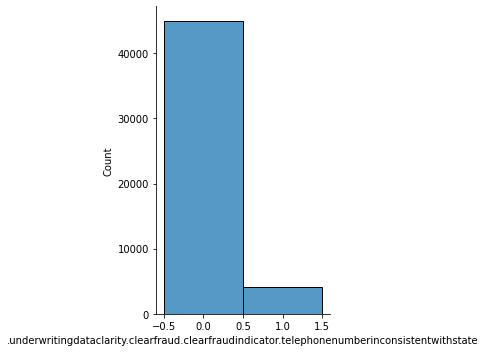

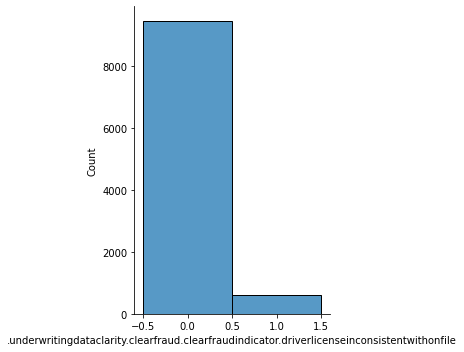

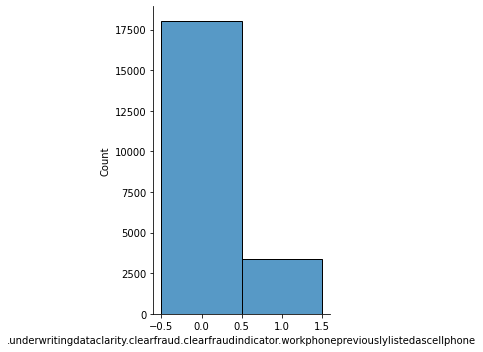

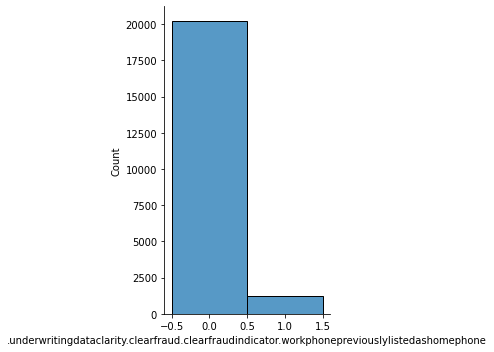

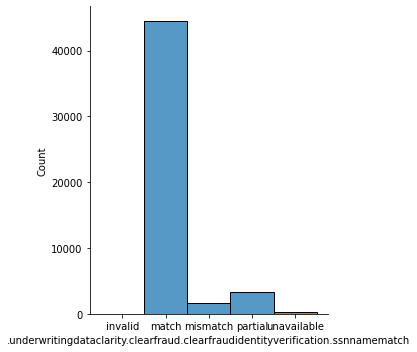

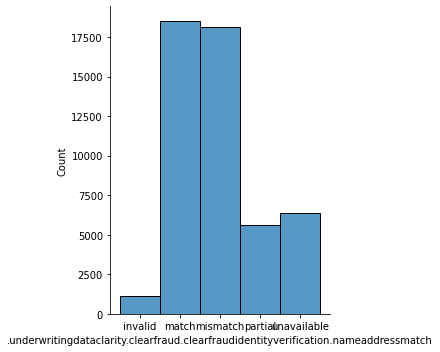

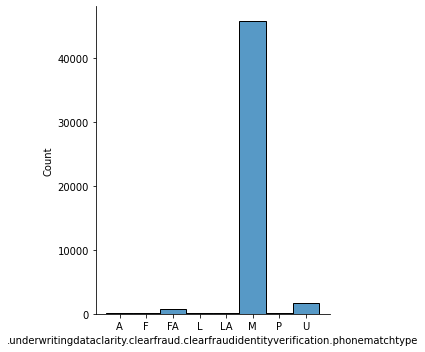

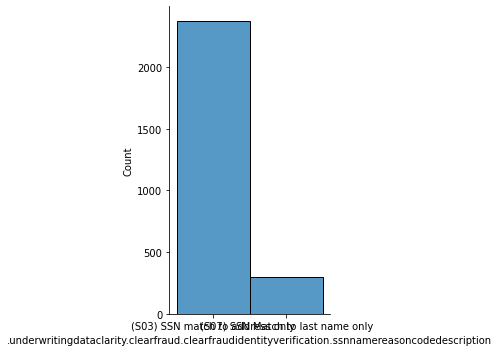

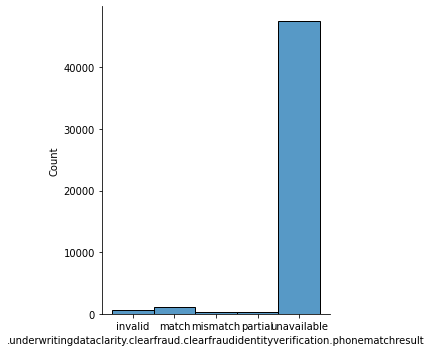

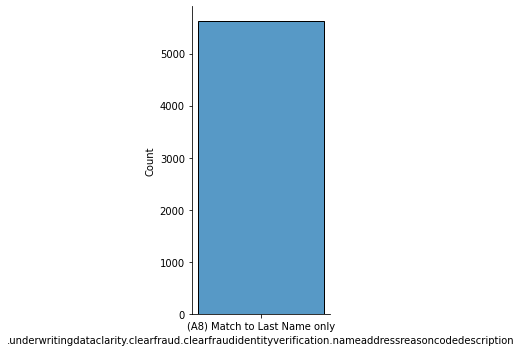

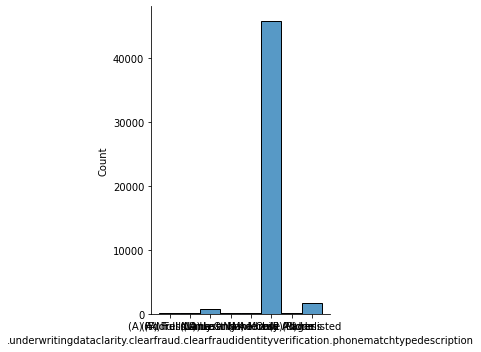

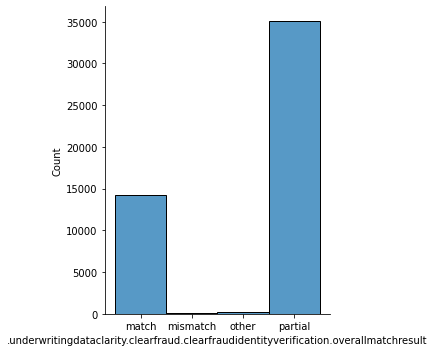

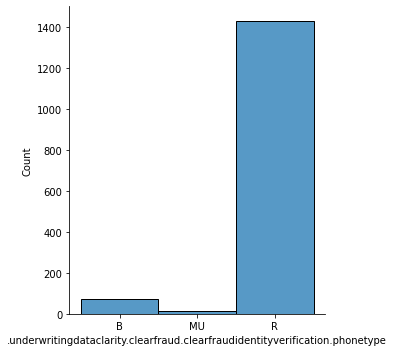

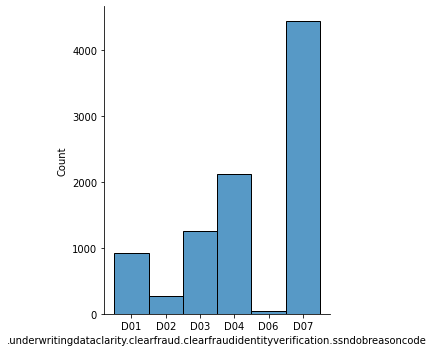

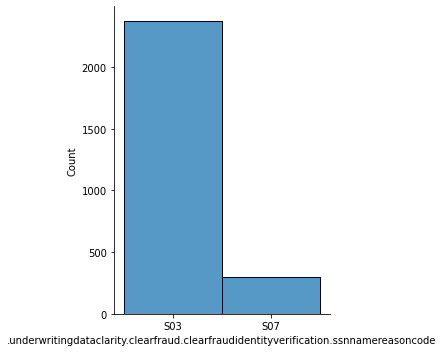

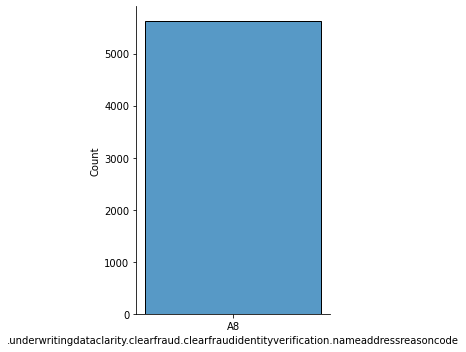

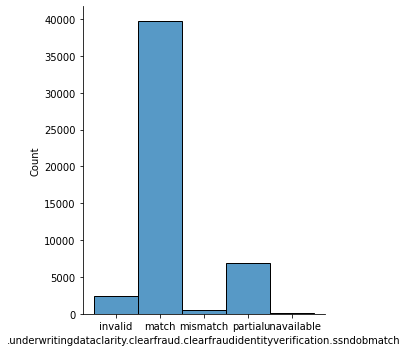

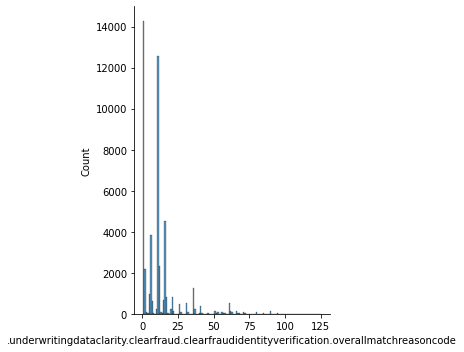

In [43]:
for col in cla_cat_col:
  sns.displot(clarity[col])

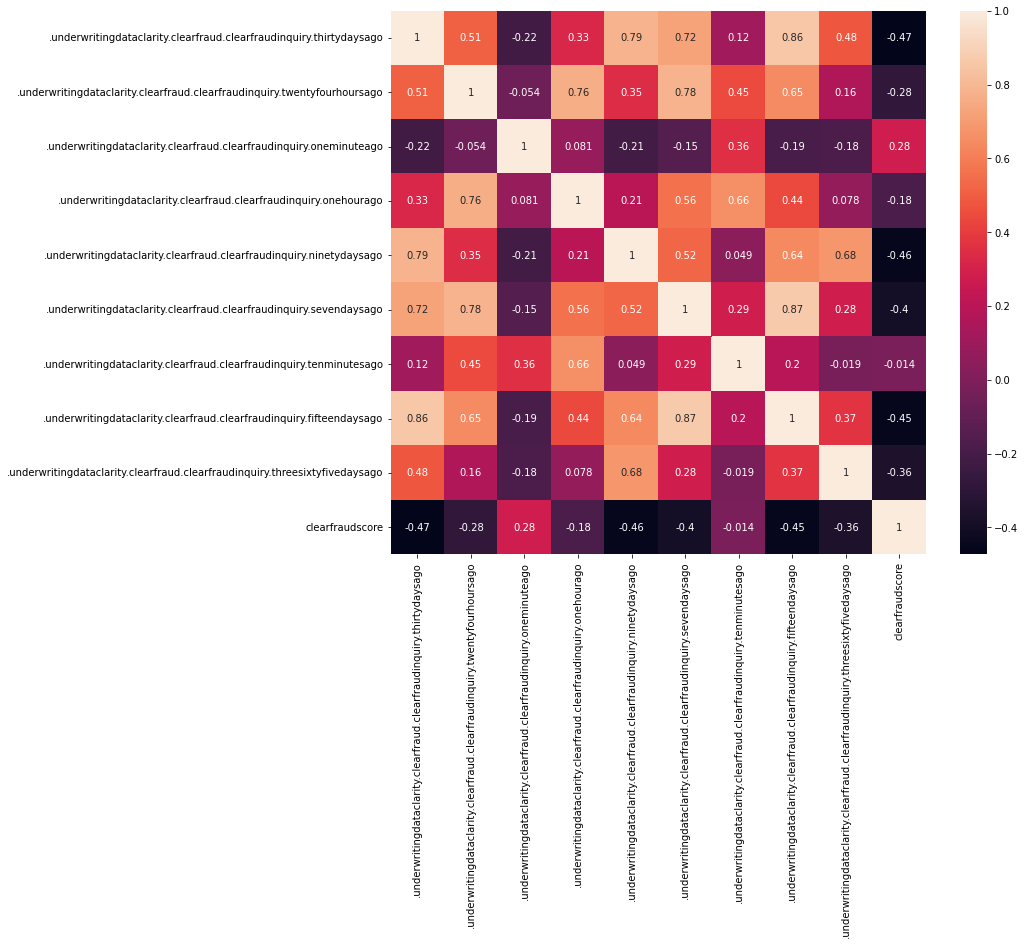

In [44]:
#check correlation
cla_corr = clarity.corr()
plt.figure(figsize=(12,10))
sns.heatmap(cla_corr, annot=True)

Not sure about some of these features, but it seems like records of clear fraud details/process..I decided to use the 'clearfraudscore' ONLY.

In [45]:
clarity = clarity[['clearfraudscore','underwritingid']]
clarity.rename(columns = {'underwritingid' : 'clarityFraudId'}, inplace = True)
clarity

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,clearfraudscore,clarityFraudId
0,871.0,54cbffcee4b0ba763e43144d
1,397.0,54cc0408e4b0418d9a7f78af
2,572.0,54cc0683e4b0418d9a80adb6
3,838.0,54cc0780e4b0ba763e43b74a
4,768.0,54cc1d67e4b0ba763e445b45
...,...,...
49747,677.0,58cc5706e4b0b0437e26b19c
49748,640.0,58cc5763e4b0b0437e272d38
49749,576.0,58cc57d4e4b0b0437e278bff
49750,830.0,58cc5916e4b0b0437e2b6e07


#Merge all
So, the strategy here is only keep the applications are funded and having clearfraudscore

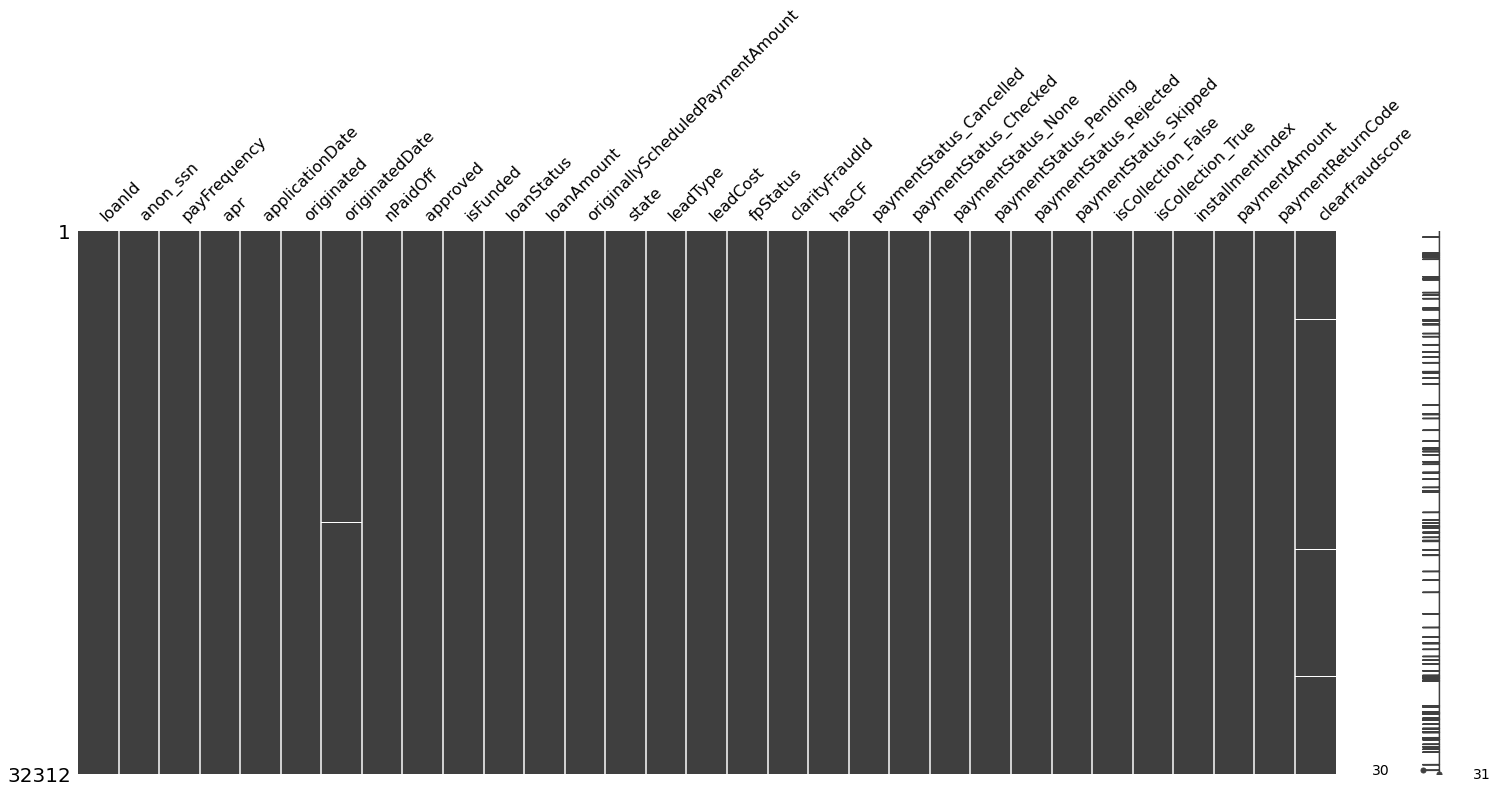

In [46]:
inner = pd.merge(loan, cleaned_pay, how="inner", on=["loanId"])
all = pd.merge(inner, clarity, how="inner", on=["clarityFraudId"])
mn.matrix(all)

In [47]:
only_funded = all[all['isFunded'].eq(1)] 
round(only_funded.isnull().sum())# 92 null value in fraud score

loanId                               0
anon_ssn                             0
payFrequency                         0
apr                                  0
applicationDate                      0
originated                           0
originatedDate                       0
nPaidOff                             2
approved                             0
isFunded                             0
loanStatus                           0
loanAmount                           0
originallyScheduledPaymentAmount     0
state                                0
leadType                             0
leadCost                             0
fpStatus                             0
clarityFraudId                       0
hasCF                                0
paymentStatus_Cancelled              0
paymentStatus_Checked                0
paymentStatus_None                   0
paymentStatus_Pending                0
paymentStatus_Rejected               0
paymentStatus_Skipped                0
isCollection_False       

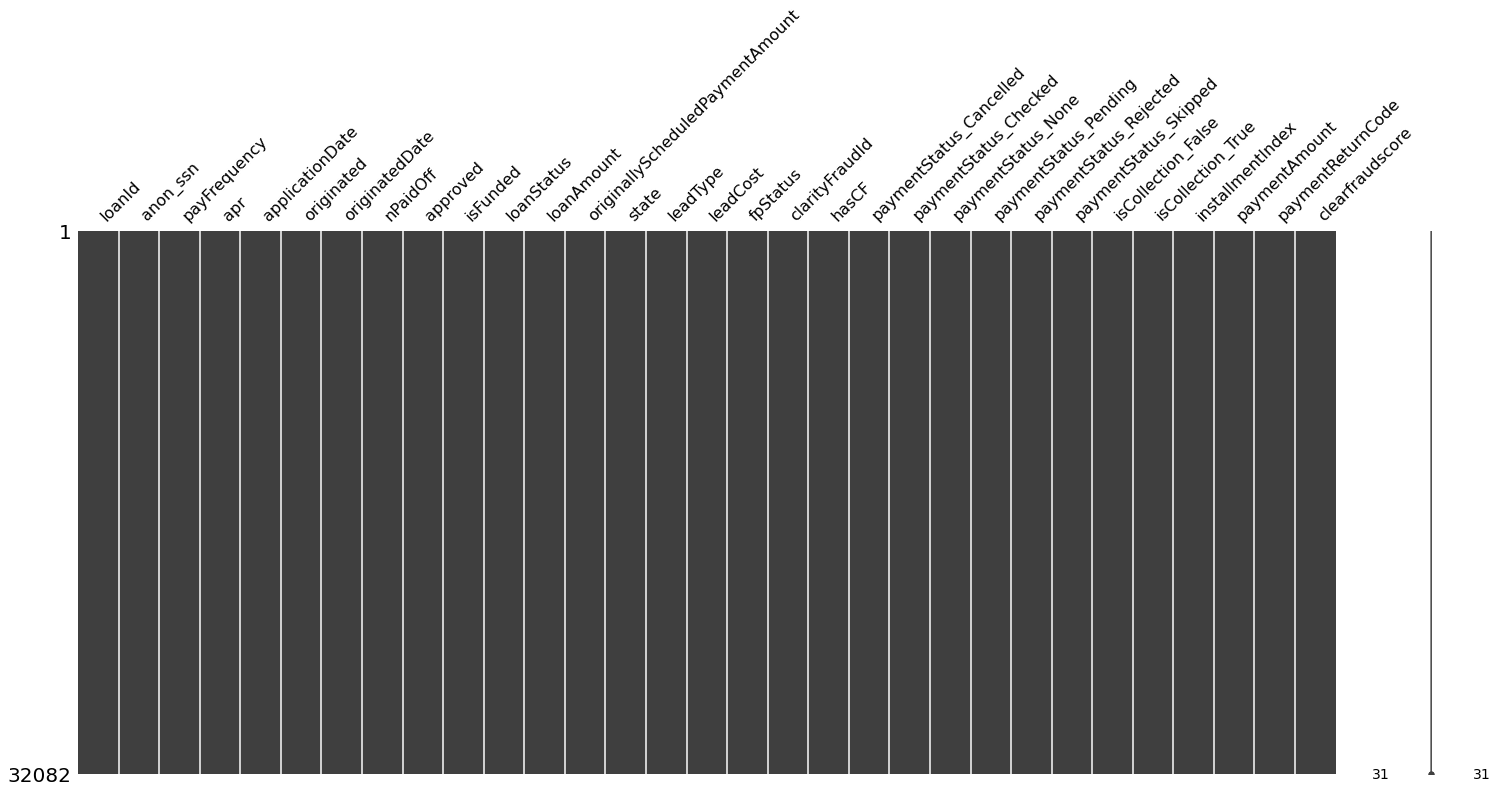

In [48]:
only_funded = only_funded.dropna() #drop null in clear fraud score
mn.matrix(only_funded)

In [49]:
#Re-assess and find the redundant columns
only_funded.info()
only_funded.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32082 entries, 0 to 32311
Data columns (total 31 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   loanId                            32082 non-null  object  
 1   anon_ssn                          32082 non-null  object  
 2   payFrequency                      32082 non-null  category
 3   apr                               32082 non-null  float64 
 4   applicationDate                   32082 non-null  object  
 5   originated                        32082 non-null  category
 6   originatedDate                    32082 non-null  object  
 7   nPaidOff                          32082 non-null  float64 
 8   approved                          32082 non-null  category
 9   isFunded                          32082 non-null  category
 10  loanStatus                        32082 non-null  category
 11  loanAmount                        32082 non-null  floa

,apr,nPaidOff,loanAmount,originallyScheduledPaymentAmount,leadCost,paymentStatus_Cancelled,paymentStatus_Checked,paymentStatus_None,paymentStatus_Pending,paymentStatus_Rejected,paymentStatus_Skipped,isCollection_False,isCollection_True,installmentIndex,paymentAmount,clearfraudscore
count,32082.000000,32082.000000,32082.000000,32082.000000,32082.000000,32082.000000,32082.000000,32082.000000,32082.000000,32082.000000,32082.000000,32082.000000,32082.000000,32082.000000,32082.000000,32082.000000
mean,532.536964,0.169721,656.496353,1805.415684,13.797394,6.725391,5.304937,4.085531,0.232747,0.843183,0.090767,16.899040,0.383517,16.920734,122.012229,685.382800
std,128.629121,0.597911,496.388090,1313.576311,21.412724,8.117326,6.051914,6.693021,0.478817,1.099831,0.319053,7.439516,2.110173,7.452334,90.141039,127.257004
min,29.990000,0.000000,100.000000,188.410000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,6.000000,-337.700000,122.000000
25%,449.000000,0.000000,400.000000,1073.912500,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,13.000000,0.000000,13.000000,65.680000,594.000000
50%,590.000000,0.000000,500.000000,1406.320000,6.000000,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,13.000000,0.000000,13.000000,95.810000,693.000000
75%,645.000000,0.000000,700.000000,2025.902500,25.000000,11.000000,8.000000,8.000000,0.000000,2.000000,0.000000,24.000000,0.000000,24.000000,150.520000,784.000000
max,681.000000,20.000000,4687.000000,16868.150000,200.000000,104.000000,48.000000,104.000000,3.000000,18.000000,9.000000,105.000000,55.000000,105.000000,1246.370000,965.000000


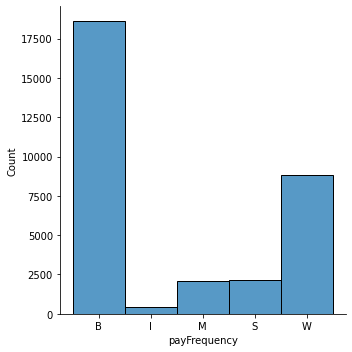

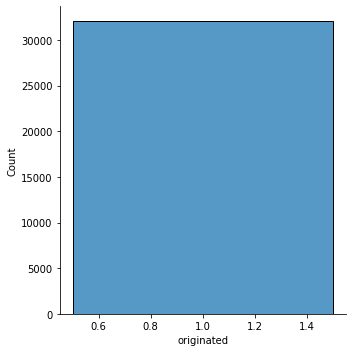

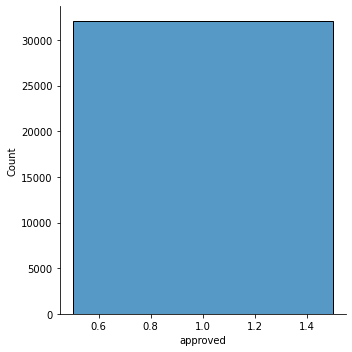

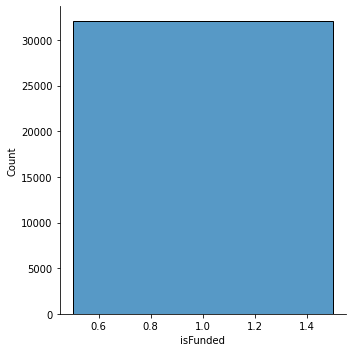

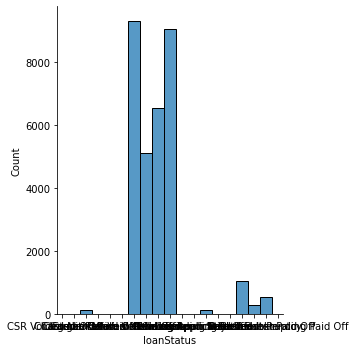

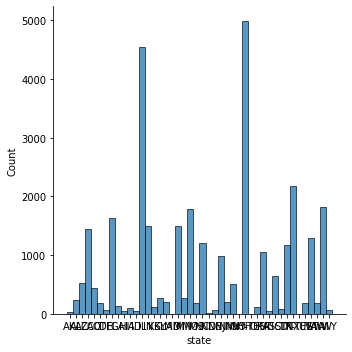

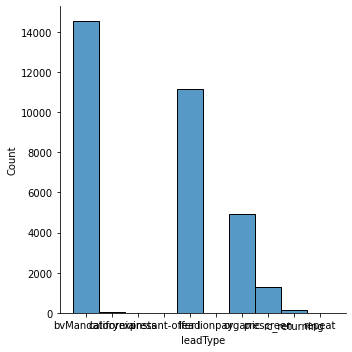

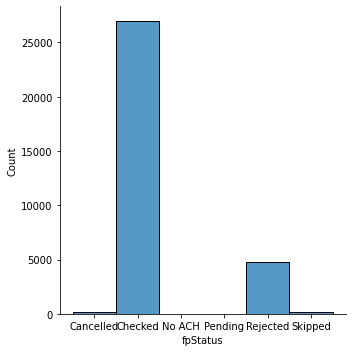

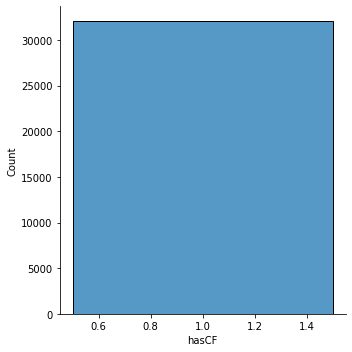

In [50]:
#only_funded.columns
cate_col = [ 'payFrequency', 'originated', 'approved', 'isFunded', 'loanStatus',
             'state', 'leadType', 'fpStatus', 'hasCF']
for i in cate_col:
  only_funded[i] =pd.Categorical(only_funded[i])

for i in cate_col:
  sns.displot(only_funded[i])


In [51]:
only_funded['paymentReturnCode'].value_counts(normalize =True) 

0         0.534256
R01       0.288043
R02       0.054111
R08       0.054111
R16       0.026619
R10       0.008011
R03       0.007855
MISSED    0.007138
RXS       0.005392
R07       0.003460
R09       0.002618
R20       0.001901
C01       0.001247
RAF       0.001060
C03       0.000966
R04       0.000935
R99       0.000810
C05       0.000468
LPP01     0.000187
RUP       0.000187
R29       0.000125
RBW       0.000094
RWC       0.000094
R06       0.000062
R13       0.000062
C02       0.000062
R19       0.000031
C07       0.000031
R15       0.000031
RIR       0.000031
Name: paymentReturnCode, dtype: float64

- Originate, approved and isfunded are redundunt features

- More than 50% are null value 0.. drop this column later

#Final cleaning

In [52]:
exclude =['loanId', 'anon_ssn', 'applicationDate', 'clarityFraudId', 'originated',
          'approved', 'isFunded', 'hasCF', 'paymentReturnCode','originatedDate']

In [53]:
df = only_funded.drop(exclude, axis=1)
df.head()

,payFrequency,apr,nPaidOff,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,fpStatus,...,paymentStatus_Checked,paymentStatus_None,paymentStatus_Pending,paymentStatus_Rejected,paymentStatus_Skipped,isCollection_False,isCollection_True,installmentIndex,paymentAmount,clearfraudscore
0,B,199.0,0.0,Paid Off Loan,3000.0,6395.19,CA,prescreen,0,Checked,...,22,0,0,0,0,25,0,25,266.47,879.0
1,W,645.0,0.0,New Loan,400.0,1364.87,NJ,lead,40,Checked,...,0,24,2,0,0,26,0,26,52.88,658.0
2,S,490.0,2.0,Paid Off Loan,1250.0,3313.78,MO,organic,0,Checked,...,1,0,0,0,0,13,0,13,276.24,835.0
3,S,490.0,3.0,Paid Off Loan,1250.0,3112.16,MO,organic,0,Checked,...,1,10,1,0,0,12,0,12,259.20,835.0
4,S,490.0,1.0,Paid Off Loan,500.0,1292.09,MO,organic,0,Checked,...,1,0,0,0,0,13,0,13,107.72,835.0


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32082 entries, 0 to 32311
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   payFrequency                      32082 non-null  category
 1   apr                               32082 non-null  float64 
 2   nPaidOff                          32082 non-null  float64 
 3   loanStatus                        32082 non-null  category
 4   loanAmount                        32082 non-null  float64 
 5   originallyScheduledPaymentAmount  32082 non-null  float64 
 6   state                             32082 non-null  category
 7   leadType                          32082 non-null  category
 8   leadCost                          32082 non-null  int64   
 9   fpStatus                          32082 non-null  category
 10  paymentStatus_Cancelled           32082 non-null  uint8   
 11  paymentStatus_Checked             32082 non-null  uint

In [55]:
#df['loanStatus'].unique().to_list()
good_loan = ['Paid Off Loan',
             'New Loan',
             'Internal Collection',
             'External Collection',
             'Returned Item',
             'Pending Paid Off',
             'Settlement Paid Off']
#make it binary
df['Target'] = np.nan

def loanStatus(status):
    if status in good_loan:
        return 1
    else:
        return 0
    
df['Target'] = df['loanStatus'].apply(loanStatus)
df = df.drop('loanStatus', axis=1)

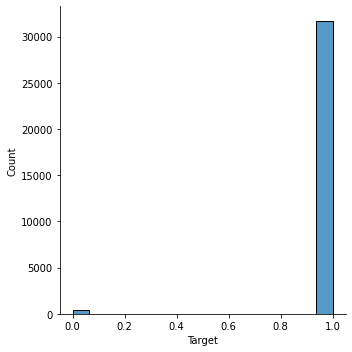

In [56]:
sns.displot(df['Target']) 

In [57]:
a = df['Target'].value_counts(normalize=True)[0] #bad
b = df['Target'].value_counts(normalize=True)[1] #good 
print('0: '+str(a),'1: '+str(b))

0: 0.01215634935477838 1: 0.9878436506452216


Very imbalance dataset, apply random over sampling later

In [58]:
# bivariate analysis
cate_col = [ 'payFrequency', 'state', 'leadType', 'fpStatus']

for i in cate_col:
  fig = px.histogram(df, x=i, color="Target",width=400, height=400)
  fig.show()

#LightGBM

In [59]:
len(df)

32082

In [60]:
# import libraries
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

from sklearn.model_selection import cross_val_score,cross_val_predict, train_test_split
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import accuracy_score,classification_report, recall_score,confusion_matrix, roc_auc_score, precision_score, f1_score, roc_curve, auc, plot_confusion_matrix,plot_roc_curve

In [61]:
X= df.drop('Target', axis=1)
y= df['Target']
onehot_encoder = OneHotEncoder()
X = onehot_encoder.fit_transform(X)

accuracy= []
recall =[]
roc_auc= []
precision = []

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)
lgbmc_base=LGBMClassifier(random_state=3, scale_pos_weight = 3)
lgbmc_base.fit(X_train, y_train,categorical_feature = 'auto',eval_set=(X_test, y_test),feature_name='auto', verbose=20)

y_pred = lgbmc_base.predict(X_test)
accuracy.append(round(accuracy_score(y_test, y_pred),4))
recall.append(round(recall_score(y_test, y_pred),4))
roc_auc.append(round(roc_auc_score(y_test, y_pred),4))
precision.append(round(precision_score(y_test, y_pred),4))

model_names = ['LightGBM_default']
result_df = pd.DataFrame({'Accuracy':accuracy,'Recall':recall, 'Roc_Auc':roc_auc, 'Precision':precision}, index=model_names)
result_df

[20]	valid_0's binary_logloss: 0.06353
[40]	valid_0's binary_logloss: 0.0636071
[60]	valid_0's binary_logloss: 0.06401
[80]	valid_0's binary_logloss: 0.0644739
[100]	valid_0's binary_logloss: 0.0655315


,Accuracy,Recall,Roc_Auc,Precision
LightGBM_default,0.9871,1.0,0.5,0.9871


AUC closer to 1 the better, 0.5 = random guess

Confusion matrix:
 [[   0  124]
 [   0 9501]]


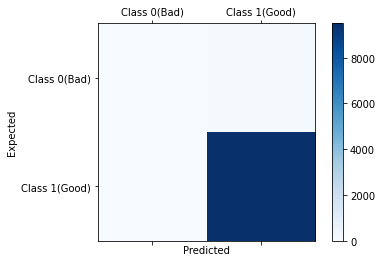

In [62]:
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)
labels = ['Class 0(Bad)', 'Class 1(Good)']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

Only predicted True Positive (Actual Good loan) as the dataset is extremely imbalanced

In [63]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)
from collections import Counter
print(sorted(Counter(y_resampled).items())) #Make it balanced, len(bad loan = good loan)

[(0, 31692), (1, 31692)]


In [64]:
accuracy= []
recall =[]
roc_auc= []
precision = []

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=3)
lgbmc_base=LGBMClassifier(random_state=3, scale_pos_weight = 3)
lgbmc_base.fit(X_train, y_train,categorical_feature = 'auto',eval_set=(X_test, y_test),feature_name='auto', verbose=20)

y_pred = lgbmc_base.predict(X_test)
accuracy.append(round(accuracy_score(y_test, y_pred),4))
recall.append(round(recall_score(y_test, y_pred),4))
roc_auc.append(round(roc_auc_score(y_test, y_pred),4))
precision.append(round(precision_score(y_test, y_pred),4))

model_names = ['LightGBM_default']
result_df = pd.DataFrame({'Accuracy':accuracy,'Recall':recall, 'Roc_Auc':roc_auc, 'Precision':precision}, index=model_names)
result_df

[20]	valid_0's binary_logloss: 0.438233
[40]	valid_0's binary_logloss: 0.333855
[60]	valid_0's binary_logloss: 0.268939
[80]	valid_0's binary_logloss: 0.228935
[100]	valid_0's binary_logloss: 0.198424


,Accuracy,Recall,Roc_Auc,Precision
LightGBM_default,0.9815,0.9629,0.9814,1.0


In [65]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      9567
           1       1.00      0.96      0.98      9449

    accuracy                           0.98     19016
   macro avg       0.98      0.98      0.98     19016
weighted avg       0.98      0.98      0.98     19016



Confusion matrix:
 [[9567    0]
 [ 351 9098]]


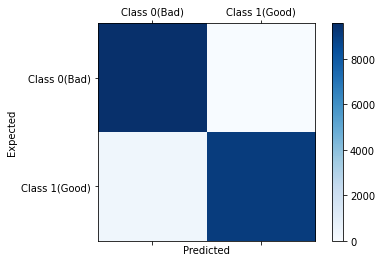

In [66]:
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)
labels = ['Class 0(Bad)', 'Class 1(Good)']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [67]:
#Fitting check
print('Training set score: {:.4f}'.format(lgbmc_base.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(lgbmc_base.score(X_test, y_test)))

Training set score: 0.9856
Test set score: 0.9815
